In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
#Feature importances
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
raw = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")
greeks = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/greeks.csv")
test = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/test.csv")

In [3]:
# https://www.kaggle.com/code/datafan07/icr-simple-eda-baseline
def balance_logloss(y_true, y_pred):
    
    y_pred = np.stack([1-y_pred,y_pred]).T
    y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    y_pred / np.sum(y_pred, axis=1)[:, None]
    nc = np.bincount(y_true)
    
    logloss = (-1/nc[0]*(np.sum(np.where(y_true==0,1,0) * np.log(y_pred[:,0]))) - 1/nc[1]*(np.sum(np.where(y_true!=0,1,0) * np.log(y_pred[:,1])))) / 2
    
    return logloss

In [4]:
df = raw.copy()

In [5]:
df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [6]:
# clean features
def clean_features(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = df.columns.str.replace(' ', '') # remove spaces
    df = df.fillna(df.mean(numeric_only=True))
    df["EJ"] = np.where(df["EJ"] == "A", 1, 0)
    return df

In [7]:
df  = df.pipe(clean_features)

## Define Features and Target

In [8]:
FEATURES = df.columns[1:-1]

In [9]:
target = df["Class"]
print(f"Out classes are imbalanced in a ration :{len(target.loc[target == 0])/len(target.loc[target == 1])} to 1 ")

Out classes are imbalanced in a ration :4.712962962962963 to 1 


In [10]:
xgb_params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'learning_rate': 0.01,
    'max_depth': 5,
    "lambda": 0.01,
    'alpha': 0.01,
    "seed": 42,
    "early_stopping_rounds":100 }


In [11]:
BAGS = 20
SEED = 42
FOLDS = 10
models={}
oof = np.zeros(len(df))
downsample_rate = 0.7

for bag in range(BAGS):
    print("-"*25)
    print(f"Bag {bag+1}")
    print("-"*25)
    models[bag]=[]
    
    simple_folds = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED+bag)
    print(simple_folds.split(X=df[FEATURES], y=df["Class"]))
    for fold, (train_idx, valid_idx) in enumerate(simple_folds.split(X=df[FEATURES], y=df["Class"])):
        print(f"=> Fold {fold+1}, ")

        #Downsampling majority class
        y_train = df.loc[train_idx, "Class"]

        remove = y_train.loc[y_train==0].sample(frac=downsample_rate, random_state=SEED+bag).index.values
        train_idx = np.setdiff1d(train_idx, remove)

        #Splitting data
        X_train = df.loc[train_idx, FEATURES]
        y_train = df.loc[train_idx, "Class"]
        X_valid = df.loc[valid_idx, FEATURES]
        y_valid = df.loc[valid_idx, "Class"]

        #Train Model
        xgb_c = xgb.XGBClassifier(**xgb_params, n_estimators=10000, n_jobs=-1,)
        xgb_c.fit(X_train, y_train, eval_set=[(X_valid, y_valid)] , verbose=0)

        oof[valid_idx] += xgb_c.predict_proba(X_valid)[:,1]/BAGS
        models[bag].append(xgb_c)

-------------------------
Bag 1
-------------------------
<generator object _BaseKFold.split at 0x7ce30ba08350>
=> Fold 1, 
=> Fold 2, 
=> Fold 3, 
=> Fold 4, 
=> Fold 5, 
=> Fold 6, 
=> Fold 7, 
=> Fold 8, 
=> Fold 9, 
=> Fold 10, 
-------------------------
Bag 2
-------------------------
<generator object _BaseKFold.split at 0x7ce30ba08430>
=> Fold 1, 
=> Fold 2, 
=> Fold 3, 
=> Fold 4, 
=> Fold 5, 
=> Fold 6, 
=> Fold 7, 
=> Fold 8, 
=> Fold 9, 
=> Fold 10, 
-------------------------
Bag 3
-------------------------
<generator object _BaseKFold.split at 0x7ce30ba08430>
=> Fold 1, 
=> Fold 2, 
=> Fold 3, 
=> Fold 4, 
=> Fold 5, 
=> Fold 6, 
=> Fold 7, 
=> Fold 8, 
=> Fold 9, 
=> Fold 10, 
-------------------------
Bag 4
-------------------------
<generator object _BaseKFold.split at 0x7ce30ba08430>
=> Fold 1, 
=> Fold 2, 
=> Fold 3, 
=> Fold 4, 
=> Fold 5, 
=> Fold 6, 
=> Fold 7, 
=> Fold 8, 
=> Fold 9, 
=> Fold 10, 
-------------------------
Bag 5
-------------------------
<generator

In [12]:
cv_logloss = balance_logloss(df["Class"].values, oof)
print("CV_score:", cv_logloss)

CV_score: 0.2487600297438558


In [13]:
import matplotlib.pyplot as plt

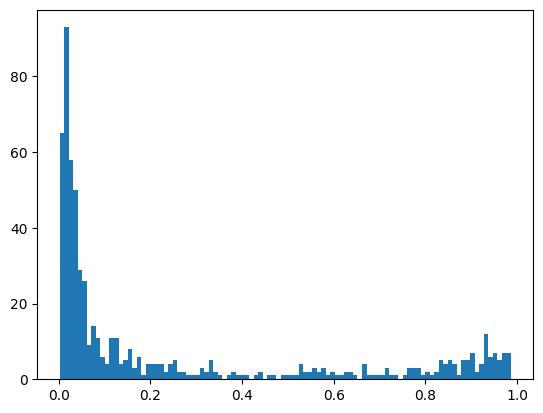

In [14]:
plt.hist(oof, bins=100)
plt.show()

## Submission

In [15]:
test = test.pipe(clean_features)

In [16]:
predictions = np.zeros(len(test))
for bag in range(BAGS):
    for xgb_c in models[bag]:
        X_test = test[FEATURES]
        predictions += xgb_c.predict_proba(X_test)[:,1]/(BAGS*FOLDS)

In [17]:
submission = pd.DataFrame({"Id": test["Id"], "class_0": 1 - predictions, "class_1": predictions})

In [18]:
submission.head()

,Id,class_0,class_1
0,00eed32682bb,0.732587,0.267413
1,010ebe33f668,0.732587,0.267413
2,02fa521e1838,0.732587,0.267413
3,040e15f562a2,0.732587,0.267413
4,046e85c7cc7f,0.732587,0.267413


In [19]:
submission.to_csv("submission.csv", index=False)